<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_2_Machine_Learning_Modeling/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Machine Learning Modeling Overview

## Selection of dataset
Chose the Detection of IoT Botnet Attacks N-BaIoT from the UCI Machine Learning Repository:

https://archive.ics.uci.edu/dataset/442/detection+of+iot+botnet+attacks+n+baiot

It is a collection of CSV files per device, each representing benign and attack traffic captured from IoT devices. There is a folder for each device. Inside each are many csv files. Each CSV contains raw feature vectors extracted from traffic windows.

# Business Understanding

## Background
A botnet is a network of internet-connected devices (like computers, phones, IoT gadgets) that have been infected with malware and are being controlled remotely by an attacker, often without the owner's knowledge.

Bot = infected device ('robot')
Net = network
botnet = a network of infected devices working together

Botnets are used for:
DDoS attacks - they flood a website until it crashes
spam campaigns - send millions of phishing emails
data theft/keylogging - steal login credentials
crypto mining - use your device to mine crypto
click fraud - fake ad clicks for revenue
spreading malware - infect other systems

How botnets work:
1. Malware infects a device (eg. via phishing, weak passowrds, open ports)
2. device becomes a "zombie" - quietly waits for commands
3. all zombie devices are controlled by a command and control (C&C) server
4. attacker sends order to launch attacks or harvest data

IoT botnets increasingly target smart devices such as doorbells, cameras, thermostats, and baby monitors, because they often have poor security, making them easy targets.

## Dataset Details
What is the N-BaIoT dataset?
It’s a benchmark dataset created by researchers to help build and evaluate machine learning models for detecting botnet attacks on Internet of Things (IoT) devices.

Key facts:
1. Contains data from 9 IoT devices (eg. doorbell, camera, baby monitor)
2. The dataset contains traffic types, including benign and multiple botnet attack types (eg. Mirai, Bashlite)
3. Files are CSVs per device, each representing one type of behavior
4. Features are pre-extracted statistical features from raw network traffic
5. No "Label" columns, but filesnames will indicate if its benign or an attack

Purpose of dataset:
To support network-based intrusion detection systems that:
1. monitor traffic from IoT devices
2. detect abnormal patterns linked to botnet activity
3. work without needing deep packet inspection (for speed and privacy)

## Project goals
1. **train a binary classifier to detect whether an IoT event is benign or attack**
2. if there's enough time, train a multi-class classification to identify specific botnet families

## Project Considerations
1. labeling - no "label" column but file names will indicate benign or attack type
2. the data is highly imbalanced. 92% of the data is labeled as attack type, while only 8% is labeled as benign. This is now a severely imbalanced classification problem which can cause models to always predict "attack", and may lead to high accuracy but poor recall on minority class (benign)



# Data Understanding

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, loguniform
from xgboost import XGBClassifier


In [ ]:
# define function to load data

def load_n_baiot_data(device_dir):
    # create empty dataframes list
    dataframes = []

    # walk through the directory structure
    for root, dirs, files in os.walk(device_dir):
        for f in files:
            # look for csv files
            if f.endswith('.csv'):
                path = os.path.join(root, f)

                # determine label based on filename
                # benign_traff.csv vs. folders named xyz_attacks w/ .csv's
                label = 'benign' if 'benign' in f.lower() else 'attack'
                print(f"Loading: {path} as {label}")

                # read the CSV files
                # use header=0 to read the first row as column names
                df = pd.read_csv(path, header=0, skiprows=0)

                # add label (benign or attack) and source file to the dataframe
                df['label'] = label
                df['source_file'] = f
                dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

# Parallelized version of loading all devices to speed up data loading
def load_all_devices(base_dir):
    device_paths = [
        (device_name, os.path.join(base_dir, device_name))
        for device_name in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, device_name))
    ]

    def load_device(device_info):
        device_name, device_path = device_info
        print(f"Loading: {device_name}")
        df = load_n_baiot_data(device_path)
        df['device'] = device_name
        return df

    # threadpoolexecutor allows for multiple function calls to be run asynchronously using threads
    with ThreadPoolExecutor() as executor:
        all_dfs = list(executor.map(load_device, device_paths))

    return pd.concat(all_dfs, ignore_index=True)

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define the folder where the data is stored

# time the loading of data
start_load = time.time()

# path for data on PC
# base_dir = r"C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot"

# path for data in google drive
base_dir = r'/content/drive/MyDrive/detection of iot botnet attacks n baiot'

# load all devices data
full_df = load_all_devices(base_dir)

# 7.7 million observations is crashing both PC and Colab. There is insufficient RAM for this much data
# Downsampling attack data to 2 million rows did not work, still not enough RAM

# Separate data by label
benign_df = full_df[full_df['label'] == 'benign']
attack_df = full_df[full_df['label'] == 'attack']

# Downsample benign to 100,000 and attack to 300,000 rows to maintain the imbalance
# consider benign=100_000 and attack=1_100_000 to preserve the almost 1:11 ratio
# use random_state=42 for reproducibility
benign_sample = benign_df.sample(n=100_000, random_state=42)
attack_sample = attack_df.sample(n=300_000, random_state=42)

# Combine attack and benign df's
balanced_df = pd.concat([benign_sample, attack_sample], ignore_index=True)

# Shuffle data randomly before splitting to prevent unintentional order bias
# without shuffling, when data is split into train/test, one set might be mostly
# attacks and the other mostly benign, leading to skewed training/evaluation or mislead performance
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# end of data loading
end_load = time.time()
print(f"Loading time: {(end_load - start_load) / 60:.2f} minutes")

# data loading time: 1.22 min on 7/20/25

Loading: Samsung_SNH_1011_N_Webcam
Loading: Provision_PT_838_Security_Camera
Loading: SimpleHome_XCS7_1002_WHT_Security_Camera
Loading: Danmini_Doorbell
Loading: SimpleHome_XCS7_1003_WHT_Security_Camera
Loading: Philips_B120N10_Baby_Monitor
Loading: Provision_PT_737E_Security_Camera
Loading: Ennio_Doorbell
Loading: Ecobee_Thermostat
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv as benign
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Ecobee_Thermostat/benign_traffic.csv as benign
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv as benign
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Ennio_Doorbell/benign_traffic.csv as benign
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv as benign
Loading: /content/drive/MyDrive

In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Columns: 118 entries, MI_dir_L5_weight to device
dtypes: float64(115), object(3)
memory usage: 360.1+ MB


In [ ]:
# examine df characteristics
print("Device dataframe shape:\n", balanced_df.shape)
print("\nDevice dataframe - # of observations:\n", balanced_df['device'].value_counts())
print("\nDevice dataframe - # of types of observations:\n", balanced_df['label'].value_counts())

Device dataframe shape:
 (400000, 118)

Device dataframe - # of observations:
 device
Philips_B120N10_Baby_Monitor                74145
Danmini_Doorbell                            53273
Provision_PT_838_Security_Camera            51927
Provision_PT_737E_Security_Camera           46128
SimpleHome_XCS7_1002_WHT_Security_Camera    46127
SimpleHome_XCS7_1003_WHT_Security_Camera    41905
Ecobee_Thermostat                           40379
Samsung_SNH_1011_N_Webcam                   24284
Ennio_Doorbell                              21832
Name: count, dtype: int64

Device dataframe - # of types of observations:
 label
attack    300000
benign    100000
Name: count, dtype: int64


Data is highly imbalanced. Will need to use stratified splits during train_test_split. Use class weights in models like logistic regression, random forest, XGBoost

Cannot rely on accuracy. Will need to use precision, recall, f1-score, ROC-AUC, and confusion matrix

In [ ]:
print("\nDevice dataframe - preview:\n", balanced_df.head())


Device dataframe - preview:
    MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.001465       65.991221            0.052599          1.019971   
1          2.867910       85.157758           54.028562          2.935829   
2          1.000000      204.000000            0.000000          1.000000   
3          1.000000       60.000000            0.000000          1.000000   
4        115.846580      490.047008        27502.792812        201.692773   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       65.882744            0.689785          1.326022       64.773152   
1       84.899705           55.591710          3.456844       83.256966   
2      204.000000            0.000000          1.000000      204.000008   
3       60.000000            0.000000          1.000000       60.000000   
4      455.606536        38925.097341        604.395494      422.819833   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpHp_L0.

In [ ]:
# check for missing values
missing_values = balanced_df.isnull().sum()[balanced_df.isnull().sum() > 0]
print(f"\nMissing values in each column:\n{missing_values}")


Missing values in each column:
Series([], dtype: int64)


There are no missing values in any feature columns

In [ ]:
# basic statistical summary
numeric_features = balanced_df.select_dtypes(include = ['int64', 'float64']).columns.tolist()

print(f"Numerical feature statistics:\n{balanced_df[numeric_features].describe()}")

Numerical feature statistics:
       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     400000.000000   400000.000000       400000.000000     400000.000000   
mean          67.270143      168.334626        13530.121201        106.082571   
std           69.355645      158.668968        24481.098679        110.137744   
min            1.000000       60.000000            0.000000          1.000000   
25%            1.000000       60.000002            0.000000          1.000031   
50%           47.725348       74.011253            1.899350         70.466261   
75%          130.076548      277.944015        21605.996486        210.134325   
max          433.165948     1452.551907       491752.379500        537.717429   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   400000.000000        4.000000e+05     400000.000000   400000.000000   
mean       168.440985        1.493765e+04        299.917650      168.832250   
std

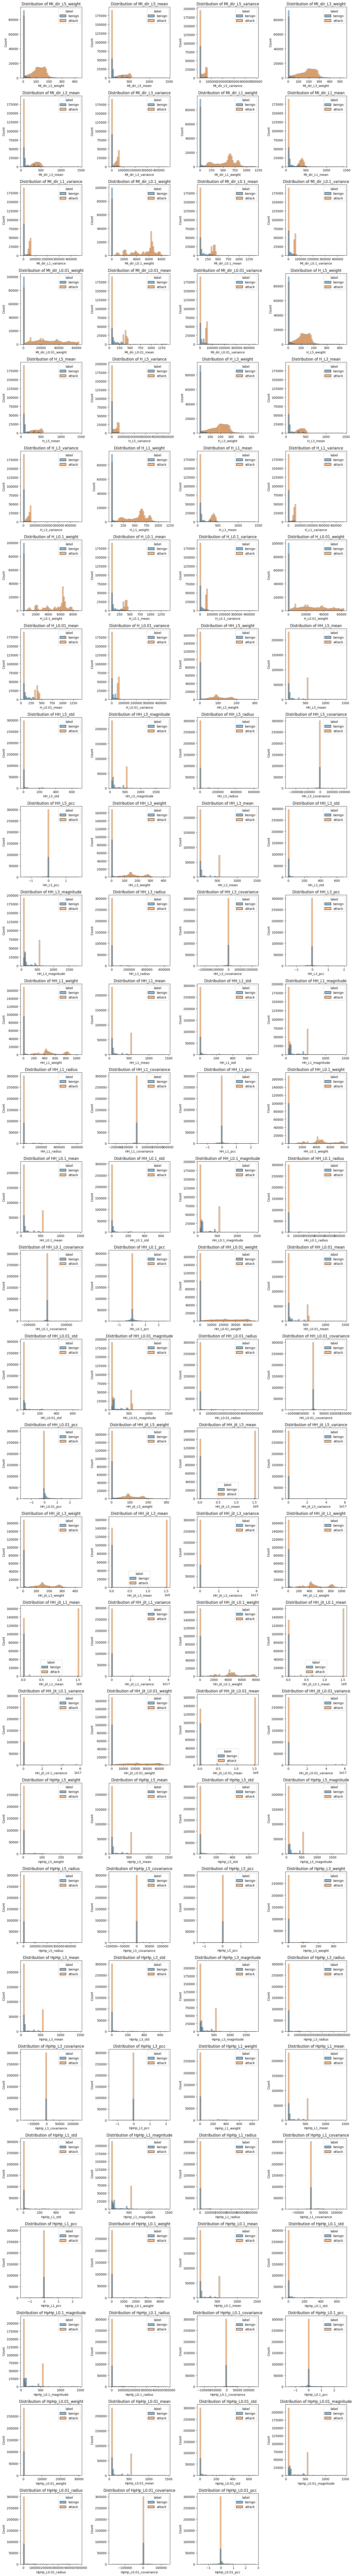

Plotting time: 1.19 minutes


In [ ]:
# examine distribution of each numeric feature

# time plotting of features
start_plot = time.time()

# determine size of plot based on number of features
n = len(numeric_features)
rows = int(np.ceil(n / 4))
plt.figure(figsize=(16, 4 * rows))

# plot histograms of numerical features

sample_df = balanced_df

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, 4, i+1)
    sns.histplot(data = sample_df, x=feature, hue='label', kde=False, bins=50)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

end_plot = time.time()
print(f"Plotting time: {(end_plot - start_plot) / 60:.2f} minutes")

# cell took 15+ min to run on 7/14/25 with kde=True
# scrap kde=true, takes too long

# cell took 1m 45s to run on 7/14/25 with kde=False and sample size 770000
# memory error occurred. Need to bin the data to reduce memory usage. set bins = 50

# plotting feature distributions time: 1.19 min on 7/20/25

# Data Preparation

Drop features where distributions are:
1. Visually identical for both classes. If the attack and benign data are completely overlapping, the feature likely carries no class separation power
2. Visually the feature is almost always zero. Its mostly 0s, so its effectively low variance

In [ ]:
selected_features = [
    "MI_dir_L5_weight", "MI_dir_L5_mean", "MI_dir_L5_variance",
    "MI_dir_L3_weight", "MI_dir_L3_mean", "MI_dir_L3_variance",
    "MI_dir_L1_weight", "MI_dir_L1_mean", "MI_dir_L1_variance",
    "MI_dir_L0.1_weight", "MI_dir_L0.1_mean", "MI_dir_L0.1_variance",
    "MI_dir_L0.01_weight", "MI_dir_L0.01_mean", "MI_dir_L0.01_variance",
    "H_L5_weight", "H_L5_mean", "H_L5_variance",
    "H_L3_weight", "H_L3_mean", "H_L3_variance",
    "H_L1_weight", "H_L1_mean", "H_L1_variance",
    "H_L0.1_weight", "H_L0.1_mean", "H_L0.1_variance",
    "H_L0.01_weight", "H_L0.01_mean", "H_L0.01_variance",
    "HH_L5_weight", "HH_L5_mean", "HH_L5_magnitude",
    "HH_L3_weight", "HH_L3_mean", "HH_L3_magnitude",
    "HH_L1_weight", "HH_L1_mean", "HH_L1_magnitude",
    "HH_L0.1_weight", "HH_L0.1_mean", "HH_L0.1_magnitude",
    "HH_L0.01_weight", "HH_L0.01_mean", "HH_L0.01_magnitude",
    "HH_jit_L5_weight", "HH_jit_L5_mean",
    "HH_jit_L3_weight", "HH_jit_L3_mean",
    "HH_jit_L1_weight", "HH_jit_L1_mean",
    "HH_jit_L0.1_weight", "HH_jit_L0.1_mean",
    "HH_jit_L0.01_weight", "HH_jit_L0.01_mean",
    "HpHp_L5_mean", "HpHp_L5_magnitude",
    "HpHp_L3_mean", "HpHp_L3_magnitude",
    "HpHp_L1_mean", "HpHp_L1_magnitude",
    "HpHp_L0.1_mean", "HpHp_L0.1_magnitude",
    "HpHp_L0.01_mean", "HpHp_L0.01_magnitude"
]

print(f"{len(selected_features)} features with visually distinct distributions were kept")

65 features with visually distinct distributions were kept


In [ ]:
# for logistic regression

# # raw scaled data
# raw_scaled = Pipeline([
#     ('scaler', StandardScaler())
# ])

# skipping raw scaled data into pipeline to save time

# log-transformed data
log_transformer = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

# combine both
# union_transformer = FeatureUnion([
#     ('raw', raw_scaled),
#     ('log', log_transformed)
# ])

# create transformer for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),
])

# use log transformed data for logistic regression only, not randomforest/xgboost
# logistic regression is a linear model and can be sensitive to skewed distributions
# log transform helps to normalize skewed features, making patterns more linear and improving model perforamnce
preprocessor_lr = ColumnTransformer(
    transformers = [
        ('log', log_transformer, selected_features),
    ]
)

# Modeling

Including an unsupervised baseline with the goal of detecting anomalies without using labels, which mimics real world situations where new attacks may not yet be labeled

[[214218  85782]
 [ 10000  90000]]
              precision    recall  f1-score   support

      benign       0.96      0.71      0.82    300000
      attack       0.51      0.90      0.65    100000

    accuracy                           0.76    400000
   macro avg       0.73      0.81      0.73    400000
weighted avg       0.84      0.76      0.78    400000



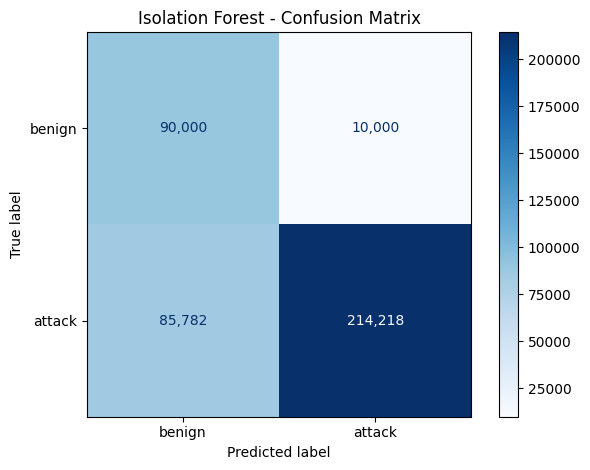

In [ ]:
from sklearn.ensemble import IsolationForest

# Use only benign samples to train
X_train_unsupervised = balanced_df[balanced_df['label'] == 'benign'].drop(columns=['label', 'source_file', 'device'], errors='ignore')

# Use all types (benign + attack) for test
X_test_unsupervised = balanced_df.drop(columns=['label', 'source_file', 'device'], errors='ignore')
y_test_unsupervised = balanced_df['label'].apply(lambda x: 'benign' if x == 'benign' else 'attack')

# Fit Isolation Forest
# contamination set to 0.1
# changed contamination to 0.25 on 7/21/25
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_unsupervised)

# Predict: -1 = anomaly (attack), 1 = normal (benign)
y_pred_unsup = iso_forest.predict(X_test_unsupervised)
y_pred_unsup = ['attack' if val == -1 else 'benign' for val in y_pred_unsup]

# Evaluate
print(confusion_matrix(y_test_unsupervised, y_pred_unsup))
print(classification_report(y_test_unsupervised, y_pred_unsup, target_names=['benign', 'attack']))

# Compute confusion matrix
cm = confusion_matrix(y_test_unsupervised, y_pred_unsup, labels=['benign', 'attack'])

# Plot confusion matrix with comma-formatted integers
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'attack'])
disp.plot(cmap='Blues', values_format=',d')  # Correct format string for comma-separated integers
plt.title("Isolation Forest - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

Confusion matrix:
True negatives: 90,000 benign events correctly identified as benign
False positives: 10,000 benign misclassified as attacks
False negatives: 85,782 attacks misclassified as benign
True positives: 214,218 attacks correctly classified as attacks

The unsupervised model is very good at catching attack events wth recall (attack = 0.90)

But when it predicts "attack" its only right ~50% of the time with precision (attack = 0.51)

When it predicts benign its correct 96% of the time with precision (benign = 0.96)

But it only catches 71% of benign events  with recall (benign = 0.71)

The model has a high false positive rate, misclassifying 86,000 benign events as attacks and low attack precision (0.51) which means many false alarms.


[[299988     12]
 [ 24998  75002]]
              precision    recall  f1-score   support

      benign       0.92      1.00      0.96    300000
      attack       1.00      0.75      0.86    100000

    accuracy                           0.94    400000
   macro avg       0.96      0.87      0.91    400000
weighted avg       0.94      0.94      0.93    400000



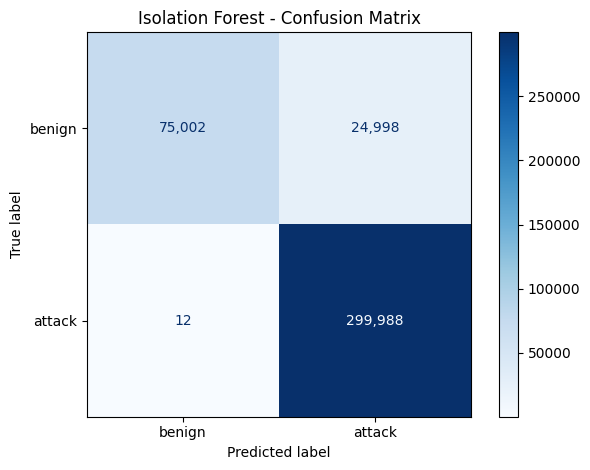

In [ ]:
# changing contamination parameter in isolationforest to 0.25 since true attackratio is 25%

# Use only benign samples to train
X_train_unsupervised = balanced_df[balanced_df['label'] == 'benign'].drop(columns=['label', 'source_file', 'device'], errors='ignore')

# Use all types (benign + attack) for test
X_test_unsupervised = balanced_df.drop(columns=['label', 'source_file', 'device'], errors='ignore')
y_test_unsupervised = balanced_df['label'].apply(lambda x: 'benign' if x == 'benign' else 'attack')

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.25, random_state=42)
iso_forest.fit(X_train_unsupervised)

# Predict: -1 = anomaly (attack), 1 = normal (benign)
y_pred_unsup = iso_forest.predict(X_test_unsupervised)
y_pred_unsup = ['attack' if val == -1 else 'benign' for val in y_pred_unsup]

# Evaluate
print(confusion_matrix(y_test_unsupervised, y_pred_unsup))
print(classification_report(y_test_unsupervised, y_pred_unsup, target_names=['benign', 'attack']))

# Compute confusion matrix
cm = confusion_matrix(y_test_unsupervised, y_pred_unsup, labels=['benign', 'attack'])

# Plot confusion matrix with comma-formatted integers
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'attack'])
disp.plot(cmap='Blues', values_format=',d')  # Correct format string for comma-separated integers
plt.title("Isolation Forest - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

True positives: 299,988 attacks correctly classified as attacks
False positives: 24,998 benign events misclassified as attacks
False negatives:12 attacks misclassified as attacks
True negatives: 75,002 benign correctly classified as benign

This modified model is aggressive about detecting attacks. Only 12 attacks were missed but 25000 benign events were false positives which can cause alert fatigue

In [ ]:
# split data into features and target

# full_df[numeric_features]
X = balanced_df[selected_features]

# remove low variance features
# from sklearn.feature_selection import VarianceThreshold
# selector = VarianceThreshold(threshold=0.01)
# X_reduced = selector.fit_transform(X)

# full_df['label'] is the target
y = balanced_df['label']

# encode target labels as binary (0 = benign, 1 = attack)
le = LabelEncoder()
y = le.fit_transform(balanced_df['label'])


In [ ]:
# split into training and test sets (80% train, 20% test), use random_state=42 and set stratify = y
# random_state=42 ensures reproducibility
# stratify y to preserve class balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random forest pipeline
# random_state=42 for reproducibility
# class weight = 'balanced' to adjust for class imbalance (benign = 8%)
# n_jobs=-1 to use all available cores for parallel processing

rf_pipeline = Pipeline(steps = [
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# create logistic regression pipeline (set random_state=42, max_iter=1000, class_weight='balanced', n_jobs=-1)
# random_state=42 for reproducibility
# max_iter=1000 to ensure convergence, but 1000 taking too long so dropped to 300
# class_weight='balanced' to adjust for class imbalance (benign = 8%)
# n_jobs=-1 to use all available cores for parallel processing

lr_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(random_state=42, max_iter=300, class_weight='balanced', n_jobs=-1))
])

# cell took 9.2 sec to run on 7/14/25

In [ ]:
# define parameter search for random search

# Define multiple scoring metrics
scoring = {
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

# define parameter distributions for random forest
rf_param_distr = {
    'classifier__max_depth': randint(5, 20),  # max depth of trees
    'classifier__min_samples_split': randint(2, 15),  # min samples to split a node
    'classifier__min_samples_leaf': randint(2, 10),  # min samples at a leaf node
    'classifier__n_estimators': randint(30, 100),  # number of trees in the forest
    'classifier__class_weight': ['balanced'],  # class weights
    'classifier__bootstrap': [True]
}

# define parameters distributions for logistic regression
lr_param_distr = {
    'classifier__C': loguniform(0.01, 10),  # regularization strength
    'classifier__class_weight': ['balanced'],  # handle imbalanced classes
    'classifier__solver': ['lbfgs']    # saga works with parallel processing for
    # all fits and runs slightly faster on large datasets
}

# use random search to get a ballpark estimate of the best parameters
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distr,
    n_iter=15,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='f1',  # refit the model based on f1, FP and FN are equally costly
    return_train_score=True,
    random_state=42,    # to ensure reproducibility
    n_jobs=-1,  # use all available cores
    verbose=1  # show progress
)

# use random search to get a ballpark estimate of the best parameters for logistic regression
lr_random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_distr,
    n_iter=30,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='f1',  # refit the model based on f1, FP and FN are equally costly
    return_train_score=True,
    random_state=42,    # to ensure reproducibility
    n_jobs=-1,  # use all available cores
    verbose=1  # show progress
)

In [ ]:
# time random forest
start_rf = time.time()

# fit the model
rf_random_search.fit(X_train, y_train)

end_rf = time.time()
print(f"Random Forest fitting time: {(end_rf - start_rf) / 60:.2f} minutes")

# Random Forest fitting time: 10.39 minutes on 7/15/25 with 5 folds, 15 candidates = 75 fits
# random forest fitting time: 9.66 min on 7/16/25 with 5 folds, 15 candidates = 75 fits
# Random Forest fitting time: 10 min on 7/16 w/ 5 folds, 15 candidates = 75 fits

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Forest fitting time: 9.58 minutes


In [ ]:
# time logistic regression
start_lr = time.time()

# fit the logistic regression model
lr_random_search.fit(X_train, y_train)

end_lr = time.time()
print(f"Logistic Regression fitting time: {(end_lr - start_lr) / 60:.2f} minutes")

# Logistic Regression fitting time: 1.30 minutes
# logistic regression fitting time: 1.15 min on 7/16/25

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Logistic Regression fitting time: 1.15 minutes


In [ ]:
print("Best logistic regression parameters:\n")
print(lr_random_search.best_params_)

print("\nBest random forest parameters:\n")
print(rf_random_search.best_params_)

Best logistic regression parameters:

{'classifier__C': np.float64(7.114476009343421), 'classifier__class_weight': 'balanced', 'classifier__solver': 'lbfgs'}

Best random forest parameters:

{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 11, 'classifier__n_estimators': 89}


In [ ]:
# optimization of hyperparameters

# define parameter grid for logistic regression
lr_param_grid = {
    # model parameters
    # using parameters from lr random search best parameters
    'classifier__C': [5, 6, 7, 8, 9],
    'classifier__class_weight': ['balanced'],
    'classifier__solver': ['lbfgs']
}

# define parameter grid for random forest
rf_param_grid = {
    'classifier__n_estimators': [85, 90, 95],
    'classifier__max_depth': [14, 15, 16],
    'classifier__min_samples_split': [10, 11, 12],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__class_weight': ['balanced']
}

# define scoring
scoring = {
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

In [ ]:
# perform grid search for random forest

# time random forest grid search
start = time.time()

# create grid search object for random forest
rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid = rf_param_grid,
    cv=3,   # cut down cv to 3 to save on grid search time
    scoring=scoring,
    refit='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# fit the random forest grid search
rf_grid_search.fit(X_train, y_train)

end = time.time()
print(f"Random Forest grid search time: {(end - start) / 60:.2f} minutes")

# Random Forest grid search time: 87.69 minutes with 5 folds, 81 candidates = 405 fits on 7/15/25
# RF grid search time: 41.75 minutes with 3 folds, 81 candidates = 243 fits on 7/16/25
# RF grid search time: 40.5 min w/ 3 folds, 81 candidates = 243 fits on 7/16/25

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest grid search time: 40.53 minutes


In [ ]:
# perform grid search for logistic regression

# time logistic regression grid search
start = time.time()

lr_grid_search = GridSearchCV(
    lr_pipeline,
    param_grid = lr_param_grid,
    cv=5,
    scoring=scoring,
    refit='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# fit the logistic regression grid search
lr_grid_search.fit(X_train, y_train)

end = time.time()
print(f"Logistic Regression grid search time: {(end - start) / 60:.2f} minutes")

# Logistic Regression grid search time: 0.19 minutes with 5 folds, 3 candidates
# logistic regression grid search time: 0.28 min w/ 5 folds, 5 candidates on 7/16/25

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Logistic Regression grid search time: 0.28 minutes


In [ ]:
#  boosting models

start = time.time()

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# get training scores
xgb_train_score = xgb_model.score(X_train, y_train)

# Cross validate all models using accuracy (don't average the scores)
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1')

end = time.time()
print(f"XGBoost fitting time: {(end - start) / 60:.2f} minutes")

# XGBoost fitting time: 0.28 minutes on 7/16/25
# XGBoost fitting time: 0.18 minutes on 7/16/25

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost fitting time: 0.18 minutes


In [ ]:
print(f"Training and Cross Validation Performance Comparison of XGBoost Model")
print(f"Extreme Gradient Boosting: Train - {xgb_train_score:.3f}, CV - {xgb_cv_scores.mean():.3f}")

Training and Cross Validation Performance Comparison of XGBoost Model
Extreme Gradient Boosting: Train - 1.000, CV - 1.000


In [ ]:
# XGBoost hyperparameter tuning

start = time.time()

xgb_grid_search = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, random_state=42)

# Create Param Grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'scale_pos_weight': [1, 3]
}

# Instantiate GridSearchCV object
grid_search = GridSearchCV(
    xgb_grid_search,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

end = time.time()
print(f"XGBoost grid search time: {(end - start) / 60:.2f} minutes")
# XGBoost grid search time: 6.61 min on 7/16/25
# XGBoost grid search time: 6.51 min on 7/16/25

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost grid search time: 6.51 minutes


# Evaluation

In [ ]:
# Evaluate function
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': name,
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:\n", cm)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Benign', 'Attack'])
    plt.title(f"\n{name} Confusion Matrix")
    plt.show()

    return metrics


Logistic Regression Confusion Matrix:
 [[59970    30]
 [   24 19976]]


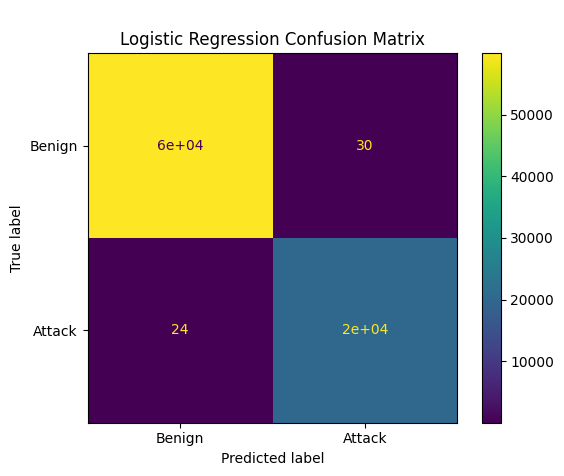


Random Forest Confusion Matrix:
 [[59986    14]
 [    1 19999]]


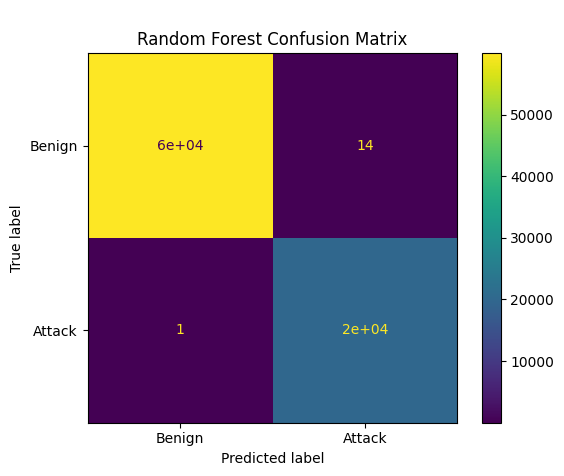


XGBoost Confusion Matrix:
 [[59997     3]
 [    0 20000]]


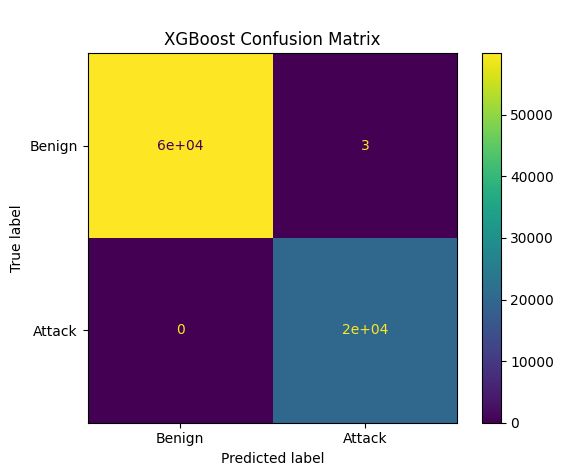

,Precision,Recall,F1 Score,ROC AUC
Model,,,,
Logistic Regression,0.999325,0.999325,0.999325,0.999861
Random Forest,0.999813,0.999812,0.999813,1.000000
XGBoost,0.999963,0.999962,0.999963,1.000000


In [ ]:
# Best logistic regression and random forest models after tuning
lr_best_model = lr_grid_search.best_estimator_
rf_best_model = rf_grid_search.best_estimator_

# Already trained XGB model (can replace with best estimator from grid_search if needed)
xgb_best_model = grid_search.best_estimator_

# Evaluate best models
lr_metrics = evaluate_model("Logistic Regression", lr_grid_search.best_estimator_, X_test, y_test)
rf_metrics = evaluate_model("Random Forest", rf_grid_search.best_estimator_, X_test, y_test)
xgb_metrics = evaluate_model("XGBoost", grid_search.best_estimator_, X_test, y_test)

# Combine into a DataFrame for comparison
results_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])
results_df = results_df.set_index('Model')
display(results_df)

Logistic Regression confusion matrix:
true negatives = 59,970 (benign correctly identifed as benign)
false positives = 30 (benign incorrectly identified as attack)
false negatives = 24 (attack incorrectly identified as benign)
true positives = 19976 (attack correctly identified as attack)

Only 24 attacks were missed, and only 30 benign events were incorrectly flagged as an attack. This means the model is not overfitting and is generalizing very well on test data.

Random forest confusion matrix:
true negatives = 59,986 (benign correctly identified as benign)
false positives = 14 (benign incorrectly identified as attack)
false negatives = 1 (attack incorrectly identified as benign)
true positives = 19,999 (attack correctly identified as attack)

Only 15 events were misclassified out of 80,000 test samples.

XGBoost confusion matrix:
true negatives = 59,997 (benign correctly identified as benign)
false positives = 3 (benign incorrectly identified as attack)
false negatives = 0 (attack incorrectly identified as benign)
true positives = 20,000 (attack correctly identified as attack)

There were 0 false negatives and only 3 benign events were misclassified as attacks.

All models present drastic improvement over the unsupervised isolation tree model.

Models are good as long as there's no data leakage, but data was stratified in train, test, split. And evaluation was performed on a held out test set

In [ ]:
# assess for overfitting for LR and RF

from sklearn.metrics import f1_score

# --- Logistic Regression ---

# Training F1
lr_train_f1 = f1_score(y_train, lr_best_model.predict(X_train), average='weighted')

# Cross-Validation F1
lr_cv_f1 = cross_val_score(lr_best_model, X_train, y_train, cv=5, scoring='f1_weighted').mean()

# Test F1
lr_test_f1 = f1_score(y_test, lr_best_model.predict(X_test), average='weighted')

print(f"Logistic Regression F1 Score:\nTrain: {lr_train_f1:.4f}, CV: {lr_cv_f1:.4f}, Test: {lr_test_f1:.4f}")

# --- Random Forest ---

# Training F1
rf_train_f1 = f1_score(y_train, rf_best_model.predict(X_train), average='weighted')

# Cross-Validation F1
rf_cv_f1 = cross_val_score(rf_best_model, X_train, y_train, cv=5, scoring='f1_weighted').mean()

# Test F1
rf_test_f1 = f1_score(y_test, rf_best_model.predict(X_test), average='weighted')

print(f"Random Forest F1 Score:\nTrain: {rf_train_f1:.4f}, CV: {rf_cv_f1:.4f}, Test: {rf_test_f1:.4f}")



Logistic Regression F1 Score:
Train: 0.9993, CV: 0.9993, Test: 0.9993
Random Forest F1 Score:
Train: 0.9999, CV: 0.9999, Test: 0.9998


Train, CV, and test f1 scores are identical, meaning the model is very stable and there is no sign of overfitting or underfitting. The models are generalized very well. This level of performance means the data is very separable and the features are highly predictive

In [ ]:
# assess for overfitting for XGBoost

# Training performance
xgb_train_f1 = f1_score(y_train, xgb_best_model.predict(X_train), average='weighted')

# Cross-validation performance (already done)
xgb_cv_f1 = cross_val_score(xgb_best_model, X_train, y_train, cv=5, scoring='f1_weighted').mean()

# Test set performance
xgb_test_f1 = f1_score(y_test, xgb_best_model.predict(X_test), average='weighted')

print(f"\nXGBoost F1 Score:\nTrain: {xgb_train_f1:.4f}, CV: {xgb_cv_f1:.4f}, Test: {xgb_test_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost F1 Score:
Train: 1.0000, CV: 1.0000, Test: 1.0000


The model perfectly classifies both classes, even on unseen data. There is no indication of overfitting as CV and test performance match training performance.

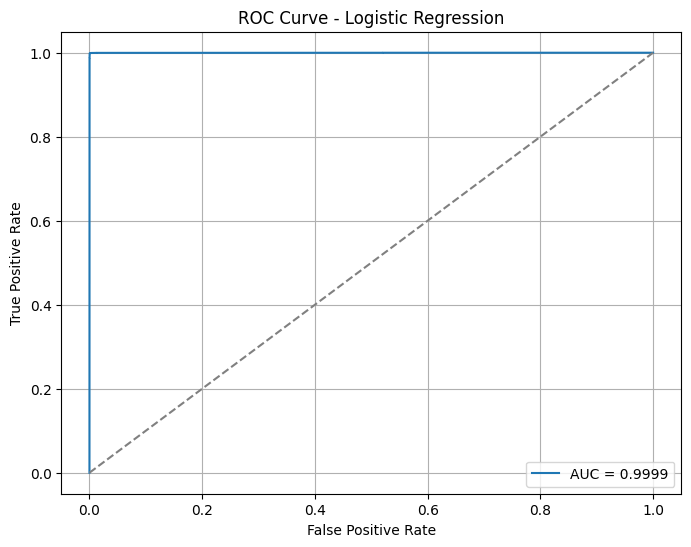

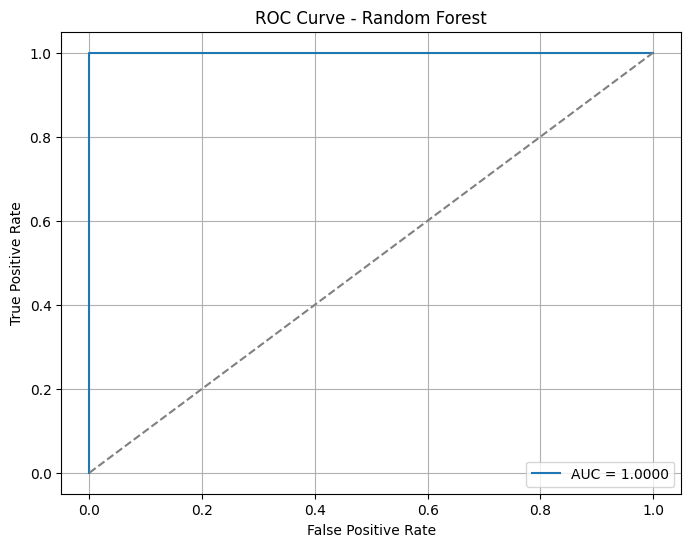

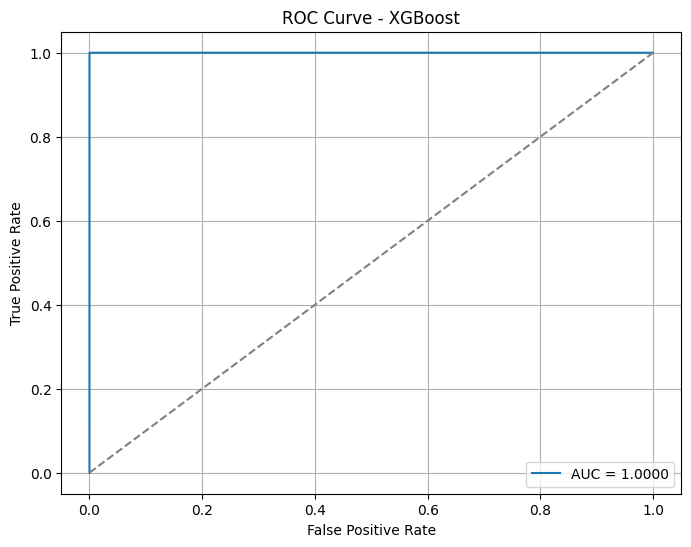

In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities
lr_probs = lr_best_model.predict_proba(X_test)[:, 1]
rf_probs = rf_best_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# --- Logistic Regression ROC ---
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'AUC = {lr_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Random Forest ROC ---
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'AUC = {rf_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- XGBoost ROC ---
plt.figure(figsize=(8, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'AUC = {xgb_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

All 3 ROC curves for logistic regression, random forest, and XGboost huge the top left corner which means the classifiers rarely misclassify benign traffic and almost always detect attacks. The models are highly capable of distinguishing between benign and attack traffic.

In [ ]:
# select best model based on F1 score
# use F1 score because both false positive and false negatives are costly
# false positive (flagging benign as attack) may overload response systems
# false negatives (flagging attack as benign) are security risks
best_model_name = results_df['F1 Score'].idxmax()

model_map = {
    'Logistic Regression': lr_grid_search.best_estimator_,
    'Random Forest': rf_grid_search.best_estimator_,
    'XGBoost': grid_search.best_estimator_
}

best_model = model_map[best_model_name]

print(f"Best model based on F1 Score: {best_model_name}")
display(results_df.sort_values(by="F1 Score", ascending=False))

Best model based on F1 Score: XGBoost


,Precision,Recall,F1 Score,ROC AUC
Model,,,,
XGBoost,0.999963,0.999962,0.999963,1.000000
Random Forest,0.999813,0.999812,0.999813,1.000000
Logistic Regression,0.999325,0.999325,0.999325,0.999861


All 3 models are performing extremely well. XGBoost has a slight edge in F1 score and ROC-AUC, making it the best choice when the priority is minimizing false positives and false negatives.

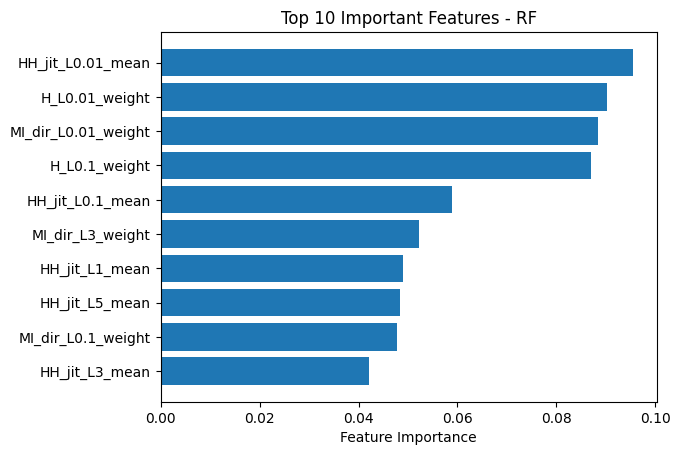

In [ ]:
# importances of features for random forest
rf_importances = rf_best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(rf_importances)[::-1][:10]
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - RF")
plt.gca().invert_yaxis()
plt.show()

	HH_jit_L0.01_mean = Mean jitter in Hurst exponent at 0.01s scale — likely measures microburst variability.
  H_L0.01_weight = Weighted entropy at 0.01s — may signal randomness in packet sizes/timing at a fine scale.
  MI_dir_L0.01_weight = Weighted directional mutual information — shows directional dependency strength at micro scale.
  H_L0.1_weight = Entropy at 0.1s — helps separate structured vs. random patterns.
  HH_jit_L0.1_mean =	Jitter in Hurst exponent at 0.1s — variability in bursty traffic patterns.

  These are the features extracted from the IoT traffic dataset that have the most impact on predicting whether an event is an attack or benign in the random forest model.

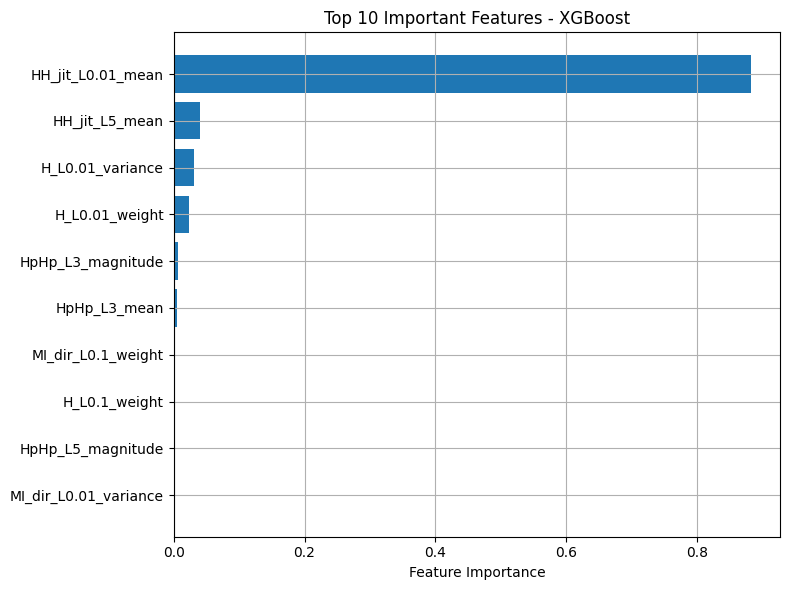

In [ ]:
# importances of features for XGBoost

# Extract feature importances from classifier step in pipeline
xgb_importances = xgb_best_model.feature_importances_

# Get feature names from training data
feature_names = X_train.columns

# Get indices of top 10 important features
sorted_idx = np.argsort(xgb_importances)[::-1][:10]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - XGBoost")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


HH_jit_L0.01_mean is by far the feature with the greatest impact on predicting whether an event is an attack or benign in the XGBoost model.

HH_jit is the feature for stats summarizing the jitter of the traffic going from this packet's host (IP) to the packet's destination host. Jitter is a measure of variability or inconsistency in the timing of data packets as they travel across a network.This information is useful for botnet detection because botnets often generate rapid, bursty, irregular traffic. Their traffic is not smooth or predictable and is randomized to avoid detection. It Botnet traffic is more chaotic than benign activity basically. HH_jit is so predictive because botnets cause high-frequency, high-variability traffic bursts, while normal IoT devices behave calmly and predictably.
Wavelet jitter features pick up on that chaos — making them powerful indicators of malicious activity.

In [ ]:
# save models to google drive
import joblib

joblib.dump(lr_best_model, '/content/drive/MyDrive/lr_best_model.pkl')
joblib.dump(rf_best_model, '/content/drive/MyDrive/rf_best_model.pkl')
joblib.dump(xgb_best_model, '/content/drive/MyDrive/xgb_best_model.pkl')

# To load:
# lr_best_model = joblib.load('/content/drive/MyDrive/lr_best_model.pkl')
# rf_best_model = joblib.load('/content/drive/MyDrive/rf_best_model.pkl')
# xgb_best_model = joblib.load('/content/drive/MyDrive/xgb_best_model.pkl')

['/content/drive/MyDrive/xgb_best_model.pkl']

# Conclusion

The final XGBoost model achieved near-perfect classification metrics. There were virtually 0 false negatives, which means attacks are almost never missed. There were very low false positives, which means benign traffic is rarely misclassified. There was consistent performance across training, cross-validation and test sets. The model is robust and generalizes well.

Business value:
The business value of this model means that it can improve network security, providing early and accurate detection of botnet traffic before devices are compromised. It provides faster incident response so that security can act quickly and confidently. It allows for lower operational cost, as false alerts are minimized reducing alert fatigue and unnecessary investigations.

Actionable recommendations:
The XGboost model should be deployed and used to flag and block suspicious traffic in real time.
Priority should be given to monitoring features like HH_jit_L0.01_mean, HH_jit_L5_mean, H_L0.01_variance, and H_L0.01_weight.
The model should continue to be trained periodically with new traffic data to ensure detection of evolving traffic patterns.

Implementation considerations and limitations:
IoT traffic patterns may evolve so regular updates of the model are required.
If attackers find out about the model, they might adapt their behavior to mimic benign patterns.
When it comes time to deploy the model in an IoT environment, it should be be a low-latency, low-memory, and offline-capable deployment. The model would have to be trained and saved, and then exported by cross-compling the XGBoost model for the IoT device and then deployed to the device.